In [8]:
# Cell 1: 导入必要的库
import torch
import torch.nn.functional as F
from transformers import CLIPModel, CLIPTokenizerFast
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
# Cell 2: 加载预训练的 CLIP 模型和 tokenizer
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_name)


In [10]:
# Cell 3: 定义文本分类数据集类
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=77):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return encoding.input_ids.squeeze(0), self.labels[idx]


In [11]:
# Cell 4: 定义加载图片的函数
def load_image_from_url(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return Image.new('RGB', (224, 224), 'black')


In [12]:
# Cell 5: 定义获取标签图片的函数
def get_label_images(label_list):
    label_to_image = {}
    # 这里使用了更具代表性的图片 URL，你可以根据需要修改
    image_urls = {
        "subjective": "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Subjektiv.svg/800px-Subjektiv.svg.png",
        "objective": "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Objective-C_Logo.svg/1200px-Objective-C_Logo.svg.png",
    }
    for label in label_list:
        img_url = image_urls.get(label)
        if img_url:
            label_to_image[label] = load_image_from_url(img_url)
        else:
            print(f"No image URL found for label: {label}")
            label_to_image[label] = Image.new('RGB', (224, 224), 'white')  # 默认白色图片
    return label_to_image


In [19]:
# Cell 6: Evaluation

def evaluate(model, dataset, batch_size=32):
    """
    评估模型性能
    Args:
        model: CLIPText模型
        dataset: 数据集
        batch_size: 批次大小
    Returns:
        accuracy: 准确率
        predictions: 预测结果
        true_labels: 真实标签
    """
    dataloader = DataLoader(dataset, batch_size=batch_size)
    predictions = []
    true_labels = []

    for texts, labels in dataloader:
        batch_preds = model.predict(texts)
        predictions.extend(batch_preds)
        true_labels.extend(labels)

    correct = sum(p == l for p, l in zip(predictions, true_labels))
    accuracy = correct / len(true_labels) * 100

    return accuracy, predictions, true_labels
def plot_confusion_matrix(true_labels, predictions, labels):
    """
    绘制混淆矩阵
    """
    cm = confusion_matrix(true_labels, predictions, labels=labels)
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [20]:
# Cell 7: 加载 Rotten Tomatoes 数据集 (用于主观性分类) 并进行预处理
from datasets import load_dataset
from sklearn.model_selection import train_test_split

dataset = load_dataset("rotten_tomatoes")

# 'rotten_tomatoes' has 'text' and 'label' fields
texts = dataset['train']['text']
labels = dataset['train']['label']

# 将数据集划分为训练集和测试集 (尽管是零样本，但为了评估方便)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# The labels in 'rotten_tomatoes' are 0 and 1. Let's map them to descriptive names.
label_names = ["negative", "positive"]
label_images = get_label_images(label_names)

def preprocess_text(examples):
    return tokenizer(examples, truncation=True, padding="max_length", max_length=77)

# 注意：这里为了简化，直接使用了标签名称作为文本输入进行编码
# 实际应用中，你可能需要更精细的标签描述或提示工程
text_labels = [f"This is a movie review with a {label} sentiment." for label in label_names]
encoded_labels = tokenizer(text_labels, padding=True, return_tensors="pt").to(device)
label_features = model.get_text_features(**encoded_labels)
label_features = label_features / label_features.norm(dim=1, keepdim=True)

test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=8)


Found cached dataset parquet (/root/.cache/huggingface/datasets/parquet/rotten_tomatoes-96cb4ca3e3ad0888/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

No image URL found for label: negative
No image URL found for label: positive


In [21]:
# Cell 8: 初始化 CLIPText 模型
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

preprocess_image = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

cliptext_model = CLIPTextModel(model, label_images, preprocess_image).to(device)


Starting prediction and evaluation...
Number of test samples: 1706
Number of labels: 2, Labels: ['negative', 'positive']

--- Processing batch 1/214 ---
Input batch shape: torch.Size([8, 77])
Text features shape: torch.Size([8, 512])
Label features shape: torch.Size([2, 512])
Similarity scores shape: torch.Size([8, 2])
Similarity scores:
[[0.8756214  0.868146  ]
 [0.7049599  0.7018995 ]
 [0.7511721  0.7444555 ]
 [0.7658532  0.759995  ]
 [0.89546376 0.8892986 ]
 [0.8688781  0.8621014 ]
 [0.8130031  0.8083087 ]
 [0.8648496  0.8646131 ]]
Predicted labels (numeric): [0 0 0 0 0 0 0 0]
Predicted labels (names): ['negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative', 'negative']
True labels (numeric): [1 0 0 0 0 0 1 1]
True labels (names): ['positive', 'negative', 'negative', 'negative', 'negative', 'negative', 'positive', 'positive']

--- Processing batch 2/214 ---
Input batch shape: torch.Size([8, 77])
Text features shape: torch.Size([8, 512])
Label features sha

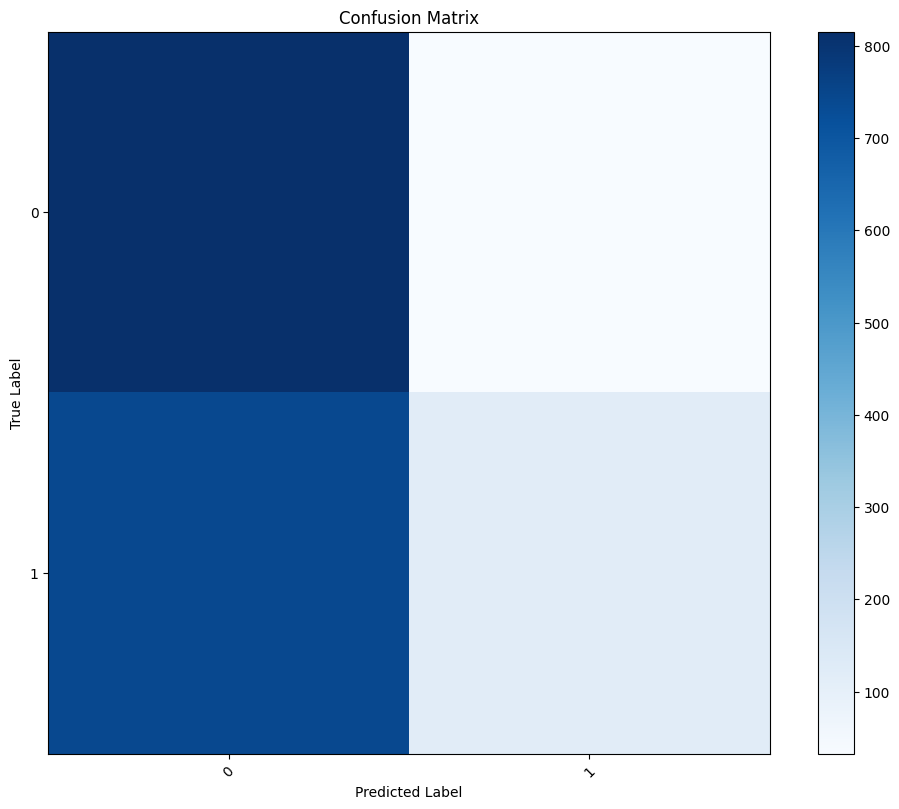

Confusion matrix plotted successfully!


In [22]:
# Cell 9: 进行预测并评估
all_predictions = []
all_true_labels = []

print("Starting prediction and evaluation...")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of labels: {len(label_names)}, Labels: {label_names}")

with torch.no_grad():
    for batch_idx, (batch_inputs, batch_labels) in enumerate(test_loader):
        print(f"\n--- Processing batch {batch_idx + 1}/{len(test_loader)} ---")
        batch_inputs = batch_inputs.to(device)
        print(f"Input batch shape: {batch_inputs.shape}")

        text_features = model.get_text_features(batch_inputs)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        print(f"Text features shape: {text_features.shape}")

        print(f"Label features shape: {label_features.shape}")

        similarity_scores = torch.matmul(text_features, label_features.T)
        print(f"Similarity scores shape: {similarity_scores.shape}")
        print(f"Similarity scores:\n{similarity_scores.cpu().numpy()}")

        predicted_labels = torch.argmax(similarity_scores, dim=1).cpu().numpy()
        print(f"Predicted labels (numeric): {predicted_labels}")
        predicted_labels_names = [label_names[i] for i in predicted_labels]
        print(f"Predicted labels (names): {predicted_labels_names}")
        print(f"True labels (numeric): {batch_labels.numpy()}")
        true_labels_names = [label_names[i] for i in batch_labels.numpy()]
        print(f"True labels (names): {true_labels_names}")

        all_predictions.extend(predicted_labels)
        all_true_labels.extend(batch_labels.numpy())

print("\n--- Evaluation Complete ---")
print("\nClassification Report:")
report = classification_report(all_true_labels, all_predictions, target_names=label_names, zero_division=0)
print(report)

# 绘制混淆矩阵
print("\n--- Generating Confusion Matrix ---")
print(f"Number of true labels: {len(all_true_labels)}")
print(f"Number of predictions: {len(all_predictions)}")
print(f"Label names for confusion matrix: {label_names}")
plot_confusion_matrix(all_true_labels, all_predictions, labels=list(range(len(label_names))))
print("Confusion matrix plotted successfully!")
